## Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime

import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

In [2]:
# We set the random seed so that the results don't vary drastically.

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

## Loading Dataset

In this cell below, we read the folder names for training and validation. We also set the `batch_size` here.

In [3]:
train_doc = np.random.permutation(open('C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/val.csv').readlines())
batch_size = 40

## Generator

This is one of the most important part of the code. The overall structure of the generator has been given here. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. (We can experiment with `img_idx`, `y`,`z` and normalization until we can get high accuracy)

In [5]:
# coding to crop and Resize of photosimages
def cropAndResize(image,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    #crop the images and resize them.  
    #Note that the images are of 2 different shape& the conv3D will throw error if the inputs in a batch have different shapes.
    # CROPPING (making aspect ratio same)
    if abs(image.shape[0]-image.shape[1])%2==0 and image.shape[0]!=image.shape[1]:
        dimension_diff=abs(image.shape[0]-image.shape[1])
        cropping_ratio=dimension_diff//2
        if image.shape[0]>image.shape[1]:
            image=image[cropping_ratio:image.shape[0]-cropping_ratio,:,:]
        elif image.shape[0]<image.shape[1]:
            image=image[:,cropping_ratio:image.shape[1]-cropping_ratio,:]
                    
    # RESIZING
    if image.shape[0]>120 or image.shape[1]>120:
        image=resize(image, (120, 120))
    return image

In [6]:
# Defininng Generator function
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24 #create a list of image no's you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size                 # calculate the number of batches
        remaining_batch_size=len(t)%batch_size
        for batch in range(num_batches):                 # we iterate over the number of batches
            batch_data = np.zeros((batch_size,16,120,120,3)) # x is the no. of images you use for each video,(y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))      # batch_labels is the one hot representation of the output
            for folder in range(batch_size):             # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # Read all the images in the folder
                for idx,item in enumerate(img_idx):      # Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = cropAndResize(image,120,120)                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255         # Normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255         # Normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels                # you yield the batch_data and the batch_labels
        for batch in range(num_batches,num_batches+1):    # iterate over the number of batches
            batch_data = np.zeros((remaining_batch_size*2,16,120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size*2,5))       # batch_labels is the one hot representation of the output
            for folder in range(remaining_batch_size):                # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = cropAndResize(image,120,120)                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255        #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255        #normalise and feed in the image
                    
                    # code for the remaining data points which are left after full batches
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [7]:
# Creating fuction for plotting results in graph
from matplotlib import pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [8]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/train'
val_path = 'C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('Validation sequences =', num_val_sequences)
num_epochs = 15              # choose the number of epochs
print ('Epochs =', num_epochs)

Training sequences = 663
Validation sequences = 100
Epochs = 15


## Model

Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,GlobalAveragePooling3D,LSTM,GlobalAveragePooling2D
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
img_idx = 7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24
input_shape = (len(img_idx), 120, 120, 3)
np.random.seed(30)

# These two steps are common for all 10 models. Make sure to run this cell before fitting any model after kernel reset

# create the `train_generator` and the `val_generator` which is used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

#defining steps per epoch

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### 1st Model : Simple Conv3D
### with Batch size = 40, No's of epoch = 10

In [10]:
model = Sequential()
model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

1. In next  `train_generator` and the `val_generator` which is defined, as it has to be used in `.fit_generator`.
2. The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make. These are also defined in cell below
3. After the model creation in above cell, the next step is to `compile` the model followed by 1st and 2nd step. In the `summary` of the model, we'll see the total number of parameters to train.

These steps are same for all the model.

In [11]:
# create the `train_generator` and the `val_generator` which is used in `.fit_generator`.

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs = 10              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 14, 118, 118, 64   5248      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 7, 59, 59, 64)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 57, 57, 128)    221312    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 28, 28, 128)    0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                        


Now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 6.2627 - categorical_accuracy: 0.2274  Source path =  C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2023-09-0112_40_27.986027\model-00001-6.26273-0.22741-1.39231-0.19167.h5
17/17 [==============================] - 1207s 70s/step - loss: 6.2627 - categorical_accuracy: 0.2274 - val_loss: 1.3923 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 1.5168 - categorical_accuracy: 0.2872  
Epoch 2: saving model to model_init_2023-09-0112_40_27.986027\model-00002-1.51676-0.28717-1.19880-0.29167.h5
17/17 [==============================] - 1162s 69s/step - loss: 1.5168 - categorical_accuracy: 0.2872 -

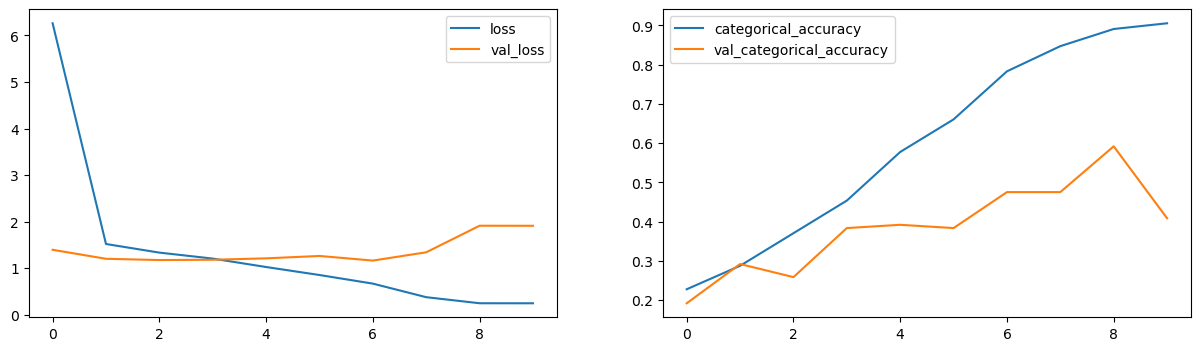

In [14]:
plot(history)

### Model 1 Output: 
- categorical_accuracy: 0.9052  
- val_categorical_accuracy: 0.4083

### Model 1 Conclusion
Model is overfit

### 2nd Model : Conv3D with BatchNormalization and Dropout
### here Batch size = 40, No of epoch = 20

In [15]:
model = Sequential()
model.add(Conv3D(64, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

num_epochs = 20              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 14, 118, 118, 64   5248      
                             )                                   
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 7, 59, 59, 64)     0         
 g3D)                                                            
                                                                 
 batch_normalization (Batch  (None, 7, 59, 59, 64)     256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 7, 59, 59, 64)     0         
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 57, 57, 128)    221312    
                                                      

In [17]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/train ; batch size = 40
Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 1.9234 - categorical_accuracy: 0.4840 Source path =  C:/Users/91997/Data Science/Casestudy_Assignments/Neural Networks Project - Gesture Recognition/Project_data/val ; batch size = 40

Epoch 1: saving model to model_init_2023-09-0112_40_27.986027\model-00001-1.92342-0.48397-2.04455-0.20833.h5
17/17 [==============================] - 1043s 61s/step - loss: 1.9234 - categorical_accuracy: 0.4840 - val_loss: 2.0446 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 0.6186 - categorical_accuracy: 0.7493 
Epoch 2: saving model to model_init_2023-09-0112_40_27.986027\model-00002-0.61864-0.74927-3.78200-0.18333.h5
17/17 [==============================] - 1017s 60s/step - loss: 0.6186 - categorical_accuracy: 0.7493 - v

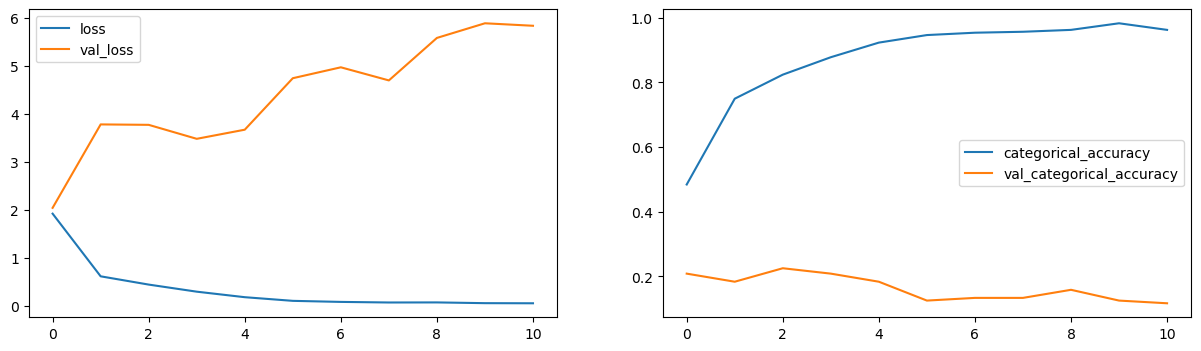

In [18]:
plot(history)

### Model 2 Output:
- categorical_accuracy: 0.9621 
- val_categorical_accuracy: 0.1167

### Model 2 Conclusion
Model is early stopping as accuracy is not increasing with each consistnet epoch.

### 3rd Model: Conv3D with BatchNormalization, Dropout and GlobalAveragePooling
### here batch_size=40, epoch=30      

In [34]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [35]:
num_epochs = 30              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 14, 118, 118, 32   2624      
                             )                                   
                                                                 
 conv3d_9 (Conv3D)           (None, 12, 116, 116, 64   55360     
                             )                                   
                                                                 
 max_pooling3d_7 (MaxPoolin  (None, 6, 58, 58, 64)     0         
 g3D)                                                            
                                                                 
 batch_normalization_14 (Ba  (None, 6, 58, 58, 64)     256       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 6, 58, 58, 64)    

In [36]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 1.4895 - categorical_accuracy: 0.4402  
Epoch 1: saving model to model_init_2023-09-0112_40_27.986027\model-00001-1.48946-0.44023-1.30331-0.17500.h5
17/17 [==============================] - 1090s 65s/step - loss: 1.4895 - categorical_accuracy: 0.4402 - val_loss: 1.3033 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 0.7881 - categorical_accuracy: 0.6312 
Epoch 2: saving model to model_init_2023-09-0112_40_27.986027\model-00002-0.78807-0.63120-1.27303-0.35000.h5
17/17 [==============================] - 1009s 59s/step - loss: 0.7881 - categorical_accuracy: 0.6312 - val_loss: 1.2730 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 0.6072 - categorical_accuracy: 0.7099 
Epoch 3: saving model to model_init_2023-09-0112_40_27.986027\model-00003-0.60723-0.70991-1.29697-0.24167.h5
17/17 [======

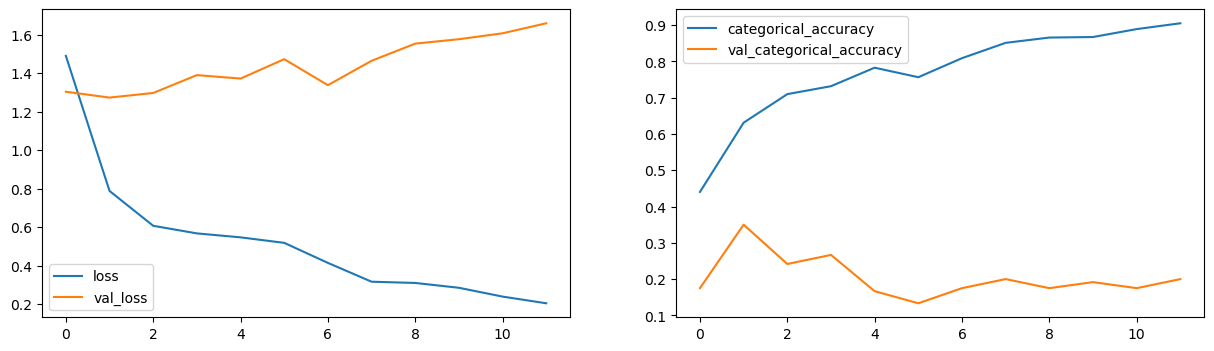

In [37]:
 plot(history)

### Model 3 Output:
- categorical_accuracy: 0.9052  
- val_categorical_accuracy: 0.20

### Model 3 Conclusion
Model is early stopping as accuracy is not increasing with each consistnet epoch.

### 4th Model: Conv2D + GRU + Batchnormalization
### here Batch_size = 40, No of epoch = 40

### Note: LSTM is not used due to Computaional constraint

In [19]:
 model = Sequential()
 model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
 model.add(TimeDistributed(MaxPooling2D((2,2))))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(TimeDistributed(GlobalAveragePooling2D()))
 model.add(TimeDistributed(Dense(64, activation='relu')))
 model.add(BatchNormalization())
 model.add(Dropout(0.2))

 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dense(5, activation='softmax'))

In [20]:
num_epochs = 40              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 118, 118, 32   896       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 59, 59, 32)    0         
 stributed)                                                      
                                                                 
 batch_normalization_3 (Bat  (None, 16, 59, 59, 32)    128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 16, 59, 59, 32)    0         
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 57, 57, 64)    18496     
 stributed)                                           

In [21]:
 history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
17/17 [==============================] - ETA: 0s - loss: 1.3336 - categorical_accuracy: 0.4227 
Epoch 1: saving model to model_init_2023-09-0112_40_27.986027\model-00001-1.33365-0.42274-1.33685-0.18333.h5
17/17 [==============================] - 214s 13s/step - loss: 1.3336 - categorical_accuracy: 0.4227 - val_loss: 1.3368 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 2/40
17/17 [==============================] - ETA: 0s - loss: 1.0229 - categorical_accuracy: 0.5423 
Epoch 2: saving model to model_init_2023-09-0112_40_27.986027\model-00002-1.02290-0.54227-1.32851-0.18333.h5
17/17 [==============================] - 199s 12s/step - loss: 1.0229 - categorical_accuracy: 0.5423 - val_loss: 1.3285 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 3/40
17/17 [==============================] - ETA: 0s - loss: 0.9762 - categorical_accuracy: 0.5510
Epoch 3: saving model to model_init_2023-09-0112_40_27.986027\model-00003-0.97617-0.55102-1.31466-0.27500.h5
17/17 [==========

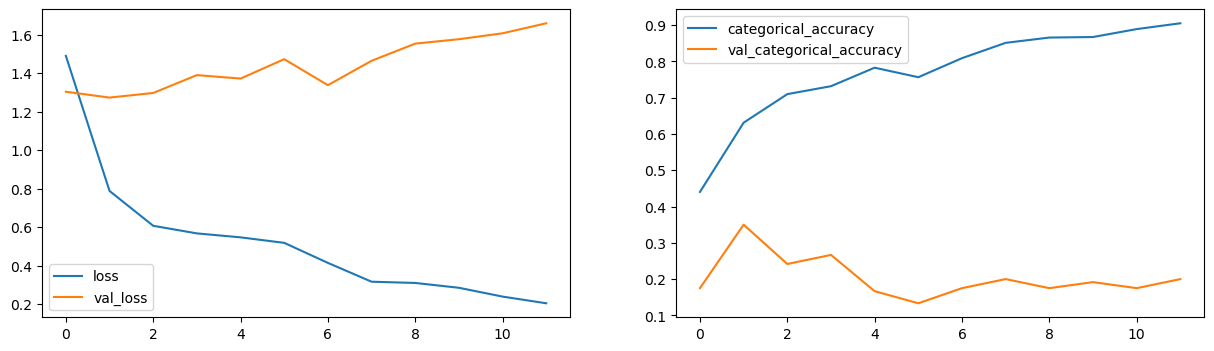

In [38]:
 plot(history)

### Model 4 Output says:
- categorical_accuracy: 0.7653  
- val_categorical_accuracy: 0.1333

### Model 4 Conclusion:
Model is early stopping as accuracy is not increasing with each consistnet epoch.

### 5th Model: TransferLearning(VGG16)  + GRU + BatchNormalization
### here batch_size=40, No of epoch = 20

In [22]:
 from keras.applications.vgg16 import VGG16
 VGG16_transfer = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)
 model = Sequential()
 model.add(TimeDistributed(VGG16_transfer,input_shape=input_shape))
 for layer in model.layers:
     layer.trainable = False

 model.add(TimeDistributed(BatchNormalization()))
 model.add(TimeDistributed(MaxPooling2D((2, 2))))
 model.add(TimeDistributed(Flatten()))
 model.add(GRU(128))
 model.add(BatchNormalization())
 model.add(Dropout(0.5))
 model.add(Dense(64,activation='relu'))
 model.add(Dropout(0.5))
        
 model.add(Dense(5, activation='softmax'))

In [23]:
num_epochs = 20              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary()) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 16, 3, 3, 512)     14714688  
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 16, 3, 3, 512)     2048      
 stributed)                                                      
                                                                 
 time_distributed_8 (TimeDi  (None, 16, 1, 1, 512)     0         
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 16, 512)           0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [24]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     callbacks=callbacks_list, validation_data=val_generator, 
                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
17/17 [==============================] - ETA: 0s - loss: 2.4927 - categorical_accuracy: 0.2507 
Epoch 1: saving model to model_init_2023-09-0112_40_27.986027\model-00001-2.49271-0.25073-1.23034-0.35000.h5
17/17 [==============================] - 804s 47s/step - loss: 2.4927 - categorical_accuracy: 0.2507 - val_loss: 1.2303 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 1.7965 - categorical_accuracy: 0.3965 
Epoch 2: saving model to model_init_2023-09-0112_40_27.986027\model-00002-1.79655-0.39650-1.12523-0.44167.h5
17/17 [==============================] - 798s 47s/step - loss: 1.7965 - categorical_accuracy: 0.3965 - val_loss: 1.1252 - val_categorical_accuracy: 0.4417 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 1.5014 - categorical_accuracy: 0.4344 
Epoch 3: saving model to model_init_2023-09-0112_40_27.986027\model-00003-1.50138-0.43440-0.99692-0.52500.h5
17/17 [=========

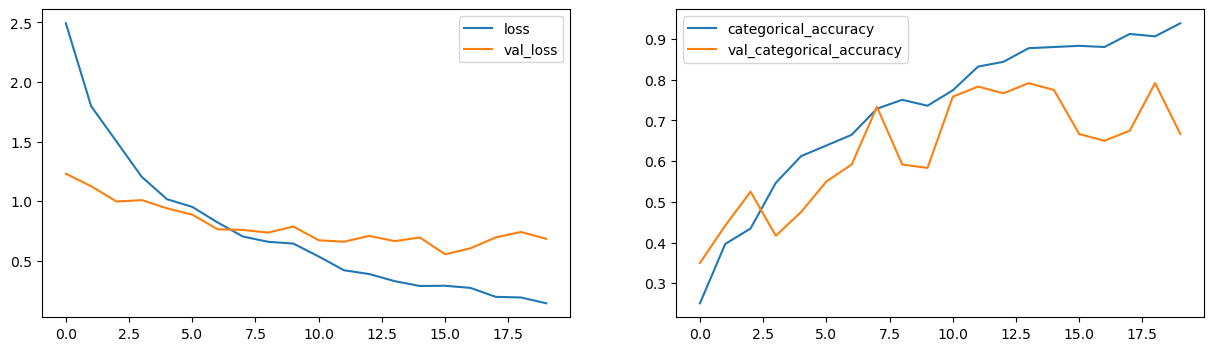

In [25]:
 plot(history)

### Model 5 Output says:
- categorical_accuracy: 0.9388  
- val_categorical_accuracy: 0.6667

### Model 5 Conclusion:
Model is still overfit.

## 6th Model: TransferLearning(Mobilenet) + GRU
### here batch size = 40, No of epoch = 15

In [26]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
 
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))
        
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

17225924/17225924 [==============================] - 4s 0us/step


In [27]:
num_epochs = 15              # choose the number of epochs

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

LR =ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4) # write the REducelronplateau code here
earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

optimiser =tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeD  (None, 16, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 16, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 16, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 16, 1024)          0         
 istributed)                                                     
                                                                 
 gru_2 (GRU)                 (None, 128)              

In [28]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.0232 - categorical_accuracy: 0.5816 
Epoch 1: val_loss improved from inf to 0.70285, saving model to model_init_2023-09-0112_40_27.986027\model-00001-1.02315-0.58163-0.70285-0.57500.h5
17/17 [==============================] - 416s 24s/step - loss: 1.0232 - categorical_accuracy: 0.5816 - val_loss: 0.7029 - val_categorical_accuracy: 0.5750 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.3800 - categorical_accuracy: 0.8149 
Epoch 2: val_loss improved from 0.70285 to 0.49756, saving model to model_init_2023-09-0112_40_27.986027\model-00002-0.38005-0.81487-0.49756-0.78333.h5
17/17 [==============================] - 400s 24s/step - loss: 0.3800 - categorical_accuracy: 0.8149 - val_loss: 0.4976 - val_categorical_accuracy: 0.7833 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.1743 - categorical_accuracy: 0.9446 
Epoch 3: val_loss improved from 0.49756 to 

### View Result

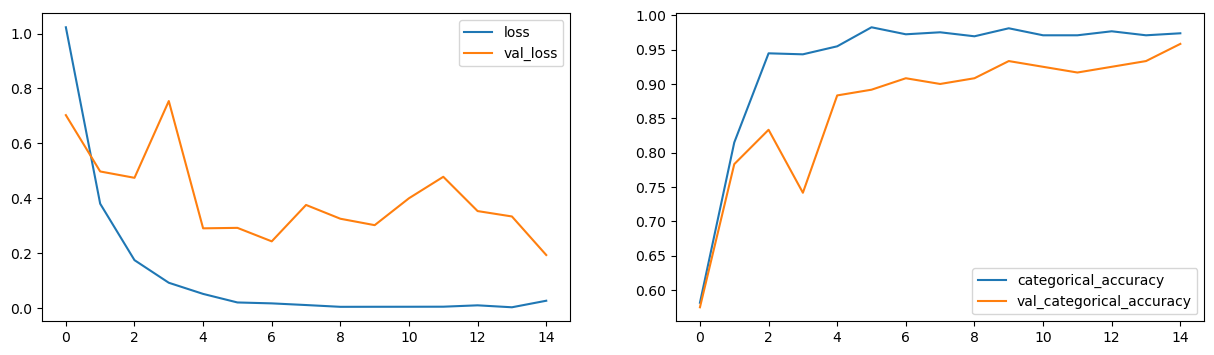

In [29]:
plot(history)

### Model 6 Output says:
- categorical_accuracy: 0.973  
- val_categorical_accuracy: 0.958

### Model 6 Conclusion: 
Model is robust.

# Final Observation
Based on the Models 1 to 6, using different learning method's (i.e., Conv3D, Conv2D+GRU, TransferLearning), the Model 6 (composed of TransferLearning from Mobilenet + GRU) gave best accuracy when compared to all above models.